ASIM AWAD HUSSEIN OSMAN - Needed help from Tim Hitge at section 2 part regarding the debug of the overtraining plot code, I was not using the range parameter in the histogram. and I was not sure about the separation of the signal/background that should be used to plot the histogram bars.
other than that, I worked alone.

# Part 1. Decision Stump by hand

## 1.1 Get and load the data
Get the train dataset and load the relevant columns in a dataframe.



In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
# prepare paths
train_path  = "/content/gdrive/MyDrive/data_atlas_higgs_4lep/ATLAS_higgs_train.csv"
test_path   = "/content/gdrive/MyDrive/data_atlas_higgs_4lep/ATLAS_higgs_test.csv"
# import the data to dataframes
train_df = pd.read_csv(train_path)
test_df  =  pd.read_csv(test_path)


In [4]:
# Explore the data
train_df.describe(),train_df.head(10),train_df.columns
# test_df.describe(),test_df.head(10),test_df.columns


(             Z1mass        Z2mass        detajj        massjj       l1pdgid  \
 count  35000.000000  35000.000000  35000.000000  35000.000000  35000.000000   
 mean      82.644232     26.473555      1.714653    185.518419     -0.042057   
 std       12.531752     10.561741      1.288890    204.113673     11.858642   
 min       13.519004      2.010767      0.000023     11.266586    -13.000000   
 25%       77.961392     19.348724      0.579244     58.344373    -11.000000   
 50%       87.695827     25.971401      1.422066    112.106252    -11.000000   
 75%       90.830151     31.848283      2.731503    234.754944     11.000000   
 max      199.438920     88.834937      4.986040   2869.846840     13.000000   
 
               l1eta         l1phi          l1pt       l2pdgid         l2eta  \
 count  35000.000000  35000.000000  35000.000000  35000.000000  35000.000000   
 mean      -0.002688     -0.013040     74.301508      0.045771      0.000866   
 std        1.054859      1.807065    

In [5]:
# Data processing and setting global variables

# GLOBAL VARIABLES
XNAME = 'detajj'; XLABEL = r'$|\Delta\eta_{jj}|$'
YNAME = 'massjj'; YLABEL = r'$m_{jj}$ (GeV)'
TARGET = 'sample'
inputs= [XNAME, YNAME] ;

XBINS = 5 ; XMIN = 0 ; XMAX = 5    ; XSTEP = 0.1
YBINS = 5 ; YMIN = 0 ; YMAX = 1000 ; YSTEP = 10
FONTSIZE = 16


# preparing the range at which the cut  of features will take place (making steps along the range of feature) will be used at the decision stumper functon
detajj_range = np.arange(XMIN,XMAX,XSTEP)
massjj_range = np.arange(YMIN,YMAX,YSTEP)



# Creating reduced datasets with detajj & massjj only
train_df = train_df[['detajj', 'massjj','sample']]
test_df = test_df[['detajj', 'massjj','sample']]

# splitting data to X,y fashion
X_train = train_df[inputs] ; y_train = train_df[['sample']]
X_test  =  test_df[inputs] ; y_test  =  test_df[['sample']]

# splittin the signal from the background in both of the train and test data

# For Training
Signal_train = train_df[train_df[TARGET] == 1]
Background_train = train_df[train_df[TARGET] == -1]

# For test
Signal_test = test_df[test_df['sample'] == 1][inputs]
Background_test = test_df[test_df['sample'] == -1][inputs]


In [6]:
type(y_train)

pandas.core.frame.DataFrame

## 1.2 Compute the Gini index

Write a function computing the Gini index value. Make your code as general as possible. Add in the next cells a series of tests to make sure your function returns the correct answers.

**Bonus**: secure your code to prevent a division by zero.

In [7]:
# function to calculate the Gini index, it takes the dataFrame, returns the index
def Gini_index(dataFrame ,target_class):

  total_samples = dataFrame.shape[0]

  #if there are no samples - prevent division bt zero
  if total_samples == 0:
      return 0
  # get the unique classws avaailable at the target ('sample') column
  classes = dataFrame[target_class].unique()
  classes_dist = {}
  # count the umber of occurances of each class
  for cls in classes:
    classes_dist[cls] = dataFrame[dataFrame[target_class] == cls].shape[0]
  # print(classes_dist)

  #calculate the gini index
  gini = 1
  for i in classes:
    gini -= (classes_dist[i]/total_samples)**2
  return gini



**Gini Index Tests**

In [9]:
# avoiding division by zero
df_zero = pd.DataFrame(columns= ['sample'])
print(Gini_index(df_zero,'sample'))

# the entire data set should be 50-50 number of samples, so a result would be 0.5
print(Gini_index(train_df,'sample'))

# another random data to calculate ging by hand (0.48)
dft = pd.DataFrame({'detajj': [10, 12, 43, 54, 665],
                    'sample': [0, 0, 0, 1, 1]
})
(Gini_index(dft, 'sample'))


0
0.5


0.48

## 1.3 Calculate the cost
Write a function computing the cost function in the CART algorithm. Again test it with a dummy dataset/example and comment.

**Bonus**: secure your code to prevent a division by zero.

In [8]:
def calculate_split_cost(dataFrame,feature, threshold , target_class):

# split the data frame according the feature and threshold
  left_df = dataFrame[dataFrame[feature] >= threshold]
  df_right = dataFrame[dataFrame[feature] < threshold]

  # calculate the nummbers of samples in each class and the total number of samples
  N_left = left_df.shape[0]
  # print(N_left)
  N_right= df_right.shape[0]
  # print(N_right)

  N_Node = N_left + N_right

  # check division by zero
  if N_Node == 0 :
    return 0
  # calculate the cost multiply gini from the left by the number of sampples on the left multiplued by the total- smae for the right side
  cost = ( (N_left * Gini_index(left_df,target_class)) +    (N_right * Gini_index(df_right,target_class))     )/N_Node

  return cost



**Example testing the function**

In [10]:
# usnig the entire traingin set
print(calculate_split_cost(train_df,feature= XNAME, threshold = 990, target_class = 'sample'))
# usin gthe previous example from gini index
dft = pd.DataFrame({'detajj': [10, 12, 43, 54, 665],
                    'sample': [0, 1, 0, 1, 1]
})
print(calculate_split_cost(dft,feature= "detajj", threshold = 50, target_class = 'sample'))
# # this should be a 2.6 cost

0.5
0.2666666666666667


## 1.4 Main function: code a Decision Stump
Write the main function decision_stumper that will call the functions defined above.

Call decision_stumper on each input feature

Conclude on the final cut for your decision stump (explain your reasoning)

Optional: if you want, you can enter a list of features and do the two steps above in the same function. Comment your code appropriately.

In [11]:
# this function takes a feature and a dataframe and gives the best position to cut along the range of this feature, the spliit with the minimum cost

def Find_best_feature_cut(dataFrame,feature, thresholds  ,target_class):
  # prepare a list to store the (cost,threshold) pairs
  costs = []
  cut = 0 # the cut starting position
  # loop over all possible cuts on the feature at hand ( we will go on a step size depending on the feature itslef)
  for point in thresholds:
    split_cost = calculate_split_cost(dataFrame,feature, point, target_class)
    # append the cost associated with this threshold to the list of costs
    costs.append((split_cost,point))
  #Finally return the threshold that corresponds to the least cost  along with the cut position (threshold)
  return min(costs)

In [12]:
Find_best_feature_cut(dataFrame=train_df,feature ='detajj', thresholds = detajj_range ,target_class ='sample')

(0.4659133723626246, 2.6)

In [13]:
# features_thresholds = {'detajj' : detajj_range ,'massjj':massjj_range}

# features_thresholds.items()

In [14]:
# Setting Some Variables
# dictionary containing the features with their ranges (problem specific to this assignment)
features_thresholds = {'detajj' : detajj_range ,'massjj':massjj_range}

def DECISION_STUMPER(dataFrame , features_thresholds , target_column):

  # list to store the costs across different features
  overall_costs = []

  # loop over every feature getting the lowest cost cut accross each, then calculating the minimum of them as the primary cut for the decision stump
  for feature,range in features_thresholds.items():
    cost , threshold = Find_best_feature_cut(dataFrame,feature,  range, target_column)
    # add this cost to the overal cost list
    overall_costs.append((cost,threshold,feature))
    # Printout to show the best cuts accross each feature
    # print(f"feature : {feature}, cost : {cost} , threshold : {threshold}")

  # Move one to perform splitting the data frame to tow dataframes based on the minimum cost calculated
  final_cut_informations = min(overall_costs)
  cost = final_cut_informations[0] # the minimum cost accross all features
  cut_threshold = final_cut_informations[1] # the most discriminative threshold
  cut_feature = final_cut_informations[2] #the most discrimnative feature (one chosen)



  # now perform the split
  left_df = dataFrame[dataFrame[cut_feature] >= cut_threshold]
  df_right = dataFrame[dataFrame[cut_feature] < cut_threshold]
  results = {'Best Feature' : cut_feature , 'best threshold ' : cut_threshold , 'best cost' : cost }

  return results

In [15]:
results = DECISION_STUMPER(train_df , features_thresholds, target_column='sample')
print(results)
optimal_threshold = results['best threshold ']

{'Best Feature': 'massjj', 'best threshold ': 220, 'best cost': 0.45639043953231406}


## 1.5 Plot the cut
Use the plot_scatter function from the second tutorial and modify it to draw the line corresponding to the optimized threshold from the decision stump. You can use Matplotlib’s axhline or axvline method for drawing a horizontal or vertical line respectively. Try to be as general as possible in the input arguments.



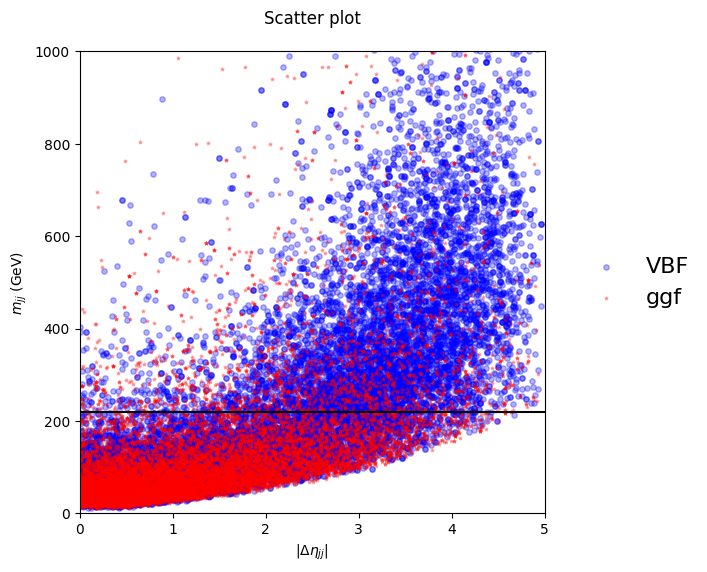

In [16]:
def plot_scatter(sig, bkg,best_threshold,
              xname=XNAME, xlabel=XLABEL, xmin=XMIN, xmax=XMAX, xstep=1,
              yname=YNAME, ylabel=YLABEL, ymin=YMIN, ymax=YMAX, ystep=200,
              fgsize=(6, 6), ftsize=16, alpha=0.3, title="Scatter plot"):

  fig, ax = plt.subplots(figsize=fgsize)

  # Annotate x-axis
  ax.set_xlim(xmin, xmax)
  ax.set_xlabel(xlabel)
  ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))

  # Annotate y-axis
  ax.set_ylim(ymin, ymax)
  ax.set_ylabel(ylabel)
  ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))

  # Scatter signal and background:
  ax.scatter(sig[xname], sig[yname], marker='o', s=15, c='b', alpha=alpha, label='VBF')
  ax.scatter(bkg[xname], bkg[yname], marker='*', s= 5, c='red', alpha=alpha, label='ggf')
  plt.axhline(y = best_threshold, c = 'black')
  # Legend and plot:
  ax.legend(fontsize=ftsize, bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
  ax.set_title(title, pad=20)
  plt.show()
plot_scatter(Signal_train, Background_train,optimal_threshold,
              xname=XNAME, xlabel=XLABEL, xmin=XMIN, xmax=XMAX, xstep=1,
              yname=YNAME, ylabel=YLABEL, ymin=YMIN, ymax=YMAX, ystep=200,
              fgsize=(6, 6), ftsize=FONTSIZE, alpha=0.3, title="Scatter plot")

# Part 2. Plotting mission: The overtraining check



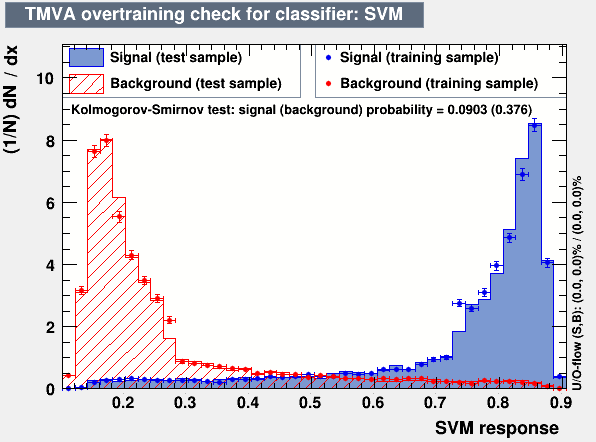

## 2.1 Understanding of the plot
Describe the plot and explain why this is called an “overtraining check” plot. Importance will be given to the clarity of your answer.

**Explanation**

The X-Axis shows the predicted probability given to each sample by the model, it serves different purposes according to the type of the data sample at hand. If it is a sifnal -> the model should predict a value close to 1.

If it is a Background -> the model should predict a value close to zero.

the filld histograms (blue and red) maps the predicted probabilties of the training data, and it shows good performance on the training set (because the majorty of the prediction are both either close to one in the signal case, and close to zero in the background case)


the other part of the plot is the performance of the model on the test set, which is showed by the red and blue crosses.
these dots or crosses do a similar behavior to the histograms, but for the test set. and as we can see, they reflect also a good erformance on the test st from the model, and a huge correlation to the training set performance,


all in all, this pattern indicate a successfull training and generalization from the mode, as it reflects a good performance on unseen data(test set)

in case f over fitting, we should see a poor performance on the test set and a good performance on the training set.

## 2.2 Reproducing the plot
Write a function plot_overtraining_check that takes as arguments the classifier object, the
 and
 lists of the training and testing sets, the value of the positive class (e.g. for VBF it is 1) and a title. The function should split each dataset (train/test) into the real category (signal/background).

To test your plotting macro, use a Decision Tree classifier of maximum depth 2. You will obtain a plot like this:

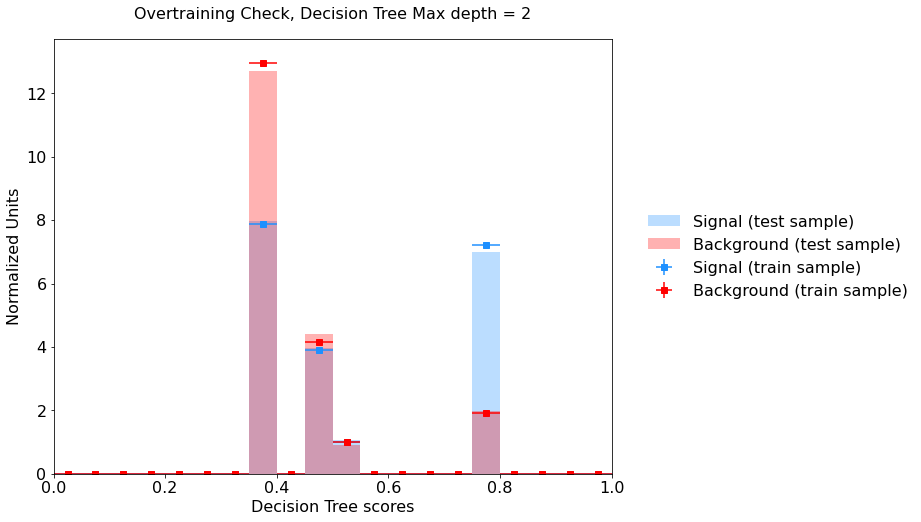

In [22]:
def plot_overtraining_check(DT,Signal_train, Background_train,
             Signal_test, Background_test,
              xname=None, xlabel=None,
              yname=None, ylabel=None,
              fgsize=(6, 6), ftsize=16, alpha=0.3, title="Overtraining Check"):

  fig, ax = plt.subplots(figsize=fgsize)

  # Annotate x-axis
  ax.set_xlabel(xlabel)

  # Annotate y-axis
  ax.set_ylabel(ylabel)

# Training Set
  sig_train_predictions = DT.predict_proba(Signal_train[inputs])[:,1]
  bkg_train_predictions = DT.predict_proba(Background_train[inputs])[:,1]

  # Test set
  sig_test_predictions = DT.predict_proba(Signal_test[inputs])[:,1]
  bkg_test_predictions = DT.predict_proba(Background_test[inputs])[:,1]



  bins = np.linspace(0, 1.0, 21)

  # this gets the hieght of the training set histogram, (the position of the point )
  sig_train_hist, binEdges = np.histogram(sig_train_predictions, bins=bins, density=True)
  bkg_train_hist, binEdges = np.histogram(bkg_train_predictions, bins=bins, density=True)
  bin_centers = 0.5 * (binEdges[1:]+binEdges[:-1])
  # # Draw the test set histogams first ## THIS IS WHERE I NEEDED HELP FROM THE BRILLIANT TIM HITGE
  ax.hist(sig_test_predictions, histtype='stepfilled', range= (0,1.0), bins = bins ,density=True, color = 'blue', alpha = 0.35, label = 'Signal - Test')
  ax.hist(bkg_test_predictions, histtype='stepfilled', range= (0,1.0), bins = bins ,density=True, color = 'red', alpha = 0.35, label = 'Background - Test')
  # ax.errorbar(sig_test_predictions , sig_train_predictions,fmt = 'o', label = 'Signal - Train')
  # ax.errorbar(bkg_train_predictions, histtype='stepfilled', range= (0,1.0), bins = 20 ,density=True, color = 'red', alpha = 0.35, label = 'Background - Train')
  # Plot error bars (Mean predicted probability for each bin in training data)
  ax.errorbar(bin_centers, sig_train_hist, yerr=np.sqrt(sig_train_hist/len(bkg_train_predictions)),
              fmt='o', color='blue', label='Signal - Train')
  # both yerr = np.sqrt(y),  and this version devided by the length can be used
  ax.errorbar(bin_centers, bkg_train_hist, yerr=np.sqrt(bkg_train_hist / len(bkg_train_predictions)),
              fmt='o', color='red', label='Background - Train')
  # https://stackoverflow.com/questions/11774822/matplotlib-histogram-with-errorbars

  # Legend and plot:
  ax.legend(fontsize=ftsize, bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
  ax.set_title(title, pad=20)
  plt.show()


### Using it with Decision Tree classifier of maximum depth 2

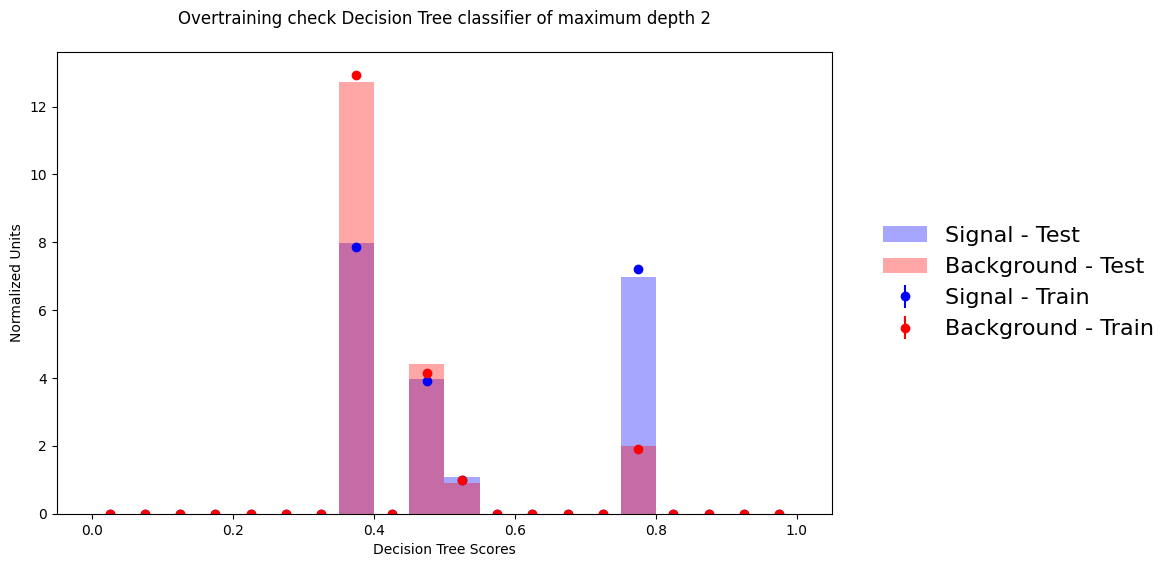

In [28]:
from sklearn.tree import DecisionTreeClassifier
DT2 = DecisionTreeClassifier(max_depth=2)
DT2= DT2.fit(X_train, y_train)
# mostly done by Tim

plot_overtraining_check(DT2,Signal_train, Background_train,
             Signal_test, Background_test,
              xname=XNAME, xlabel='Decision Tree Scores',
              yname=YNAME, ylabel='Normalized Units',
             fgsize=(10, 6), ftsize=FONTSIZE,title = "Overtraining check Decision Tree classifier of maximum depth 2",
             alpha=0.3)



## 2.3 Using the plot
Create a random forest classifier with 100 estimators and leave other hyperparameters as default. Plot the overtraining check with this classifier. What are your observations? Is it classifying well on the training set? Is is under- or overtrain? Why?

Create a second random forest classifier with this time the option max_leaf_nodes=32. What is improved? What is still problematic?

### The 100 Estimator Random Forest

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


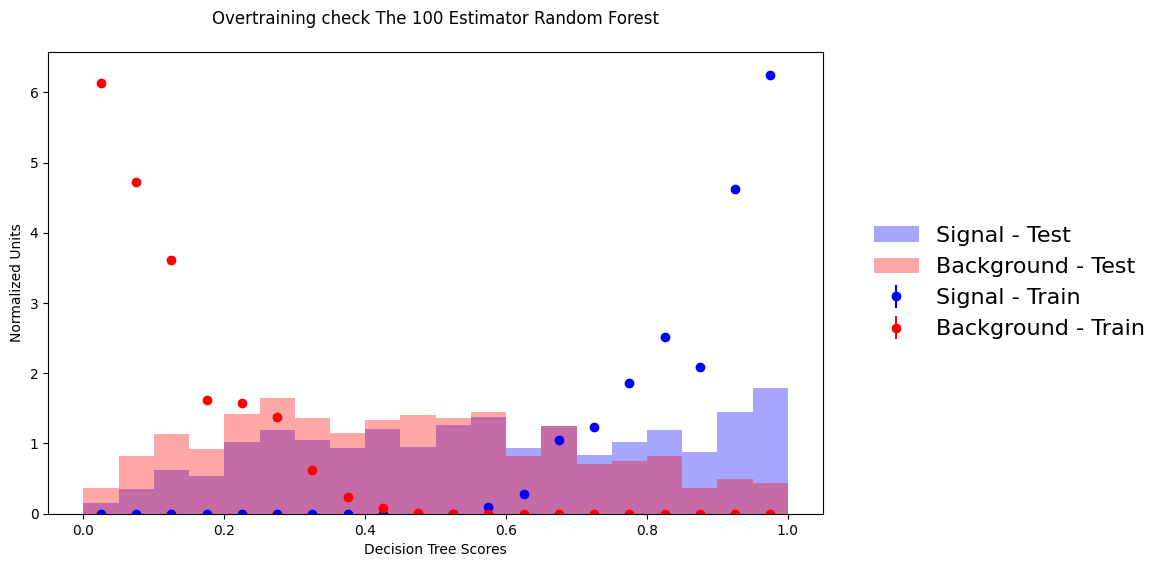

In [27]:
from sklearn.ensemble import RandomForestClassifier
RF100 = RandomForestClassifier(n_estimators=100)
RF100= RF100.fit(X_train, y_train)
# mostly done by Tim

plot_overtraining_check(RF100,Signal_train, Background_train,
             Signal_test, Background_test,
              xname=XNAME, xlabel='Decision Tree Scores',
              yname=YNAME, ylabel='Normalized Units',
             fgsize=(10, 6), ftsize=FONTSIZE,title= "Overtraining check The 100 Estimator Random Forest",
             alpha=0.3)

My observation is that this classifier extremely overfits the training set because it performs well on the trainng set (the red and blue dots reflect accurate predictions)

But when it comes to the test set it performs very poorly as you can see, i nearly has a uniform distribution among the probabilities , reflecting no learning, and also a big contrast between the training and test performance

**In short** : Good performance on training set + poor performance on the test set -> overfitting


### The 32 Max leaf Random Forest

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


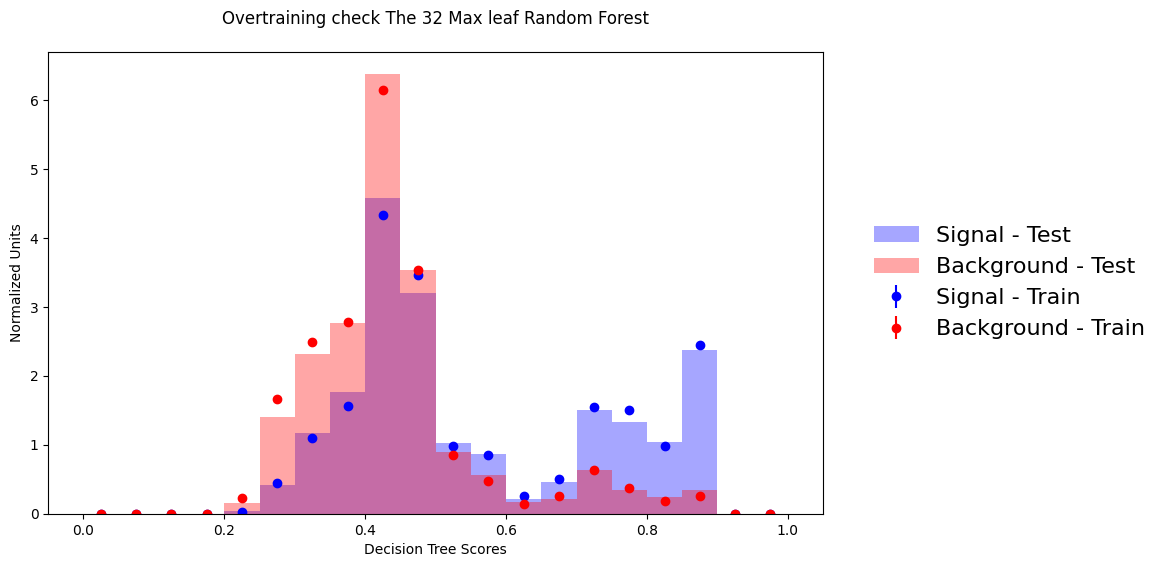

In [29]:
from sklearn.ensemble import RandomForestClassifier
RF32 = RandomForestClassifier(n_estimators=100, max_leaf_nodes=32)
RF32= RF32.fit(X_train, y_train)
# mostly done by Tim

plot_overtraining_check(RF32,Signal_train, Background_train,
             Signal_test, Background_test,
              xname=XNAME, xlabel='Decision Tree Scores',
              yname=YNAME, ylabel='Normalized Units',
             fgsize=(10, 6), ftsize=FONTSIZE,  title = "Overtraining check The 32 Max leaf Random Forest" ,
             alpha=0.3)

Now thats a huge improvement!!!

the training performance is not perfect but good at the same time, a sign of no overfitting, the test set is also good with a clear pattern of separation between the negaive and postive samplse, but the biggest indicatioin of no overfitting is the correlation between the train and test performances, indicationg that the model is generalizing well to unseen data

#  Trials and Errors during the assignment

In [ ]:
def plot_scatter(P_train, P_test,
              xname=XNAME, xlabel=XLABEL, xmin=XMIN, xmax=XMAX, xstep=1,
              yname=YNAME, ylabel=YLABEL, ymin=YMIN, ymax=YMAX, ystep=200,
              fgsize=(6, 6), ftsize=16, alpha=0.3, title="Scatter plot"):

  fig, ax = plt.subplots(figsize=fgsize)

  # Annotate x-axis
  ax.set_xlim(xmin, xmax)
  ax.set_xlabel("Predictions")
  # ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))

  # Annotate y-axistions2= DT2.predict_proba(Background_train)

  # ax.set_ylim(ymin, ymax)
  ax.set_ylabel("occurances")
  # ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))

  # Scatter signal and background:

  ax.hist(P_test[:,0],histtype='stepfilled', bins = 5 ,density=True , color = 'red', alpha = 0.5, label = 'bkg_test')
  ax.hist(P_test[:,1],histtype='stepfilled', bins = 5 ,density=True, color = 'blue', alpha = 0.5, label = 'sig_test')
  # Legend and plot:
  ax.legend(fontsize=ftsize, bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
  ax.set_title(title, pad=20)
  plt.show()
plot_scatter(P_train, P_test,
              xname=XNAME, xlabel=XLABEL, xmin=0, xmax=1, xstep=0.2,
              yname=YNAME, ylabel=YLABEL, ymin=0, ymax=12, ystep=2,
              fgsize=(6, 6), ftsize=FONTSIZE, alpha=0.3, title="Scatter plot")


In [ ]:
#check class
DTree.classes_

In [ ]:
# sig_train_predictions

In [ ]:
# Draw the training class distribution as a histogram
fig, ax  = plt.subplots()
# ax.hist(sig_train_predictions,histtype='stepfilled', bins = 5 ,density=True, color = 'blue', alpha = 0.5, label = 'Signal')
# ax.hist(bkg_train_predictions, histtype='stepfilled', bins = 5 ,density=True, color = 'red', alpha = 0.5, label = 'Background')

# ax.hist(sig_test_predictions, histtype='stepfilled', bins = 5 ,density=True, color = 'black', alpha = 0.5, label = 'Signal')
# ax.hist(bkg_test_predictions, histtype='stepfilled', bins = 5 ,density=True, color = 'green', alpha = 0.5, label = 'Background')

In [ ]:
prediction = DTree.predict_proba(X_train)
n = prediction[y_train==0]
p = prediction[y_train==1]
plt.figure(figsize=(15,7))
plt.hist(n, bins=20,density=True, label='Backgroun' )
plt.hist(p, bins=20,density=True ,  label='Signal')

plt.legend(fontsize=5)
plt.show()

In [ ]:
Signal_train = train_df[train_df['sample'] == 1][inputs]
Background_train = train_df[train_df['sample'] == -1][inputs]
Signal_test = test_df[test_df['sample'] == 1][inputs]
Background_test = test_df[test_df['sample'] == -1][inputs]


In [ ]:
# predictions3= DT2.predict_proba(Signal_test)
# predictions4= DT2.predict_proba(Background_test)

# # Background_train
# bkg_train_predictions = predictions[:,0]
# sig_train_predictions = predictions[:,1]

# Training Set
# Test set
test_predictions= DT2.predict_proba(Signal_test)
test_predictions= DT2.predict_proba(Background_test)
bkg_test_predictions = test_predictions[:,0]
sig_test_predictions = test_predictions[:,1]

In [ ]:
# Training Set
sig_train_predictions = DT2.predict_proba(Signal_test)[:,1]
bkg_train_predictions = DT2.predict_proba(Background_test)[:,1]

# Test set
sig_test_predictions = DT2.predict_proba(Signal_test)[:,1]
bkg_test_predictions = DT2.predict_proba(Background_test)[:,1]


# Draw the training class distribution as a histogram
fig, ax  = plt.subplots()
ax.hist(sig_train_predictions,histtype='stepfilled',bins = 5 ,density=True, color = 'blue', alpha = 0.5, label = 'Signal')
ax.hist(bkg_train_predictions, histtype='stepfilled', bins = 5 ,density=True, color = 'red', alpha = 0.5, label = 'Background')

ax.hist(sig_test_predictions, histtype='stepfilled', bins = 5 ,density=True, color = 'black', alpha = 0.5, label = 'Signal')
ax.hist(bkg_test_predictions, histtype='stepfilled', bins = 5 ,density=True, color = 'green', alpha = 0.5, label = 'Background')